In [0]:
import torch
import torch.nn as nn

import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


## Data

In [0]:
path_train = '/content/drive/My Drive/Data/kaggle/rsna2019/rsna2019/4500_256/valid/'
path_valid = '/content/drive/My Drive/Data/kaggle/rsna2019/rsna2019/4500_256/100/'
batch_size = 50

# Image Augmentation
- PyTorch에서 2D image dataset에 대한 주요 augmentation은 torchvision에서 제공하는 transforms들을 통해 손쉽게 구현할 수 있습니다. torchvision에서 제공하는 다양한 transform들은 아래의 링크를 통해 확인할 수 있습니다.
- https://pytorch.org/docs/stable/torchvision/transforms.html

In [0]:
trainset = torchvision.datasets.ImageFolder(root = path_train,transform=transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                                                                          transforms.Resize((224,224)),
                                                                                          transforms.ToTensor()]))

# trainset with image augmentations
trainset_augment = torchvision.datasets.ImageFolder(root = path_train,transform=transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                                                                          #transforms.RandomHorizontalFlip(),
                                                                                          transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3),
                                                                                          transforms.RandomAffine((-10,10), shear=10, scale=(0.9, 1.2)),
                                                                                          transforms.Resize((256,256)),
                                                                                          transforms.CenterCrop(224),  
                                                                                          transforms.ToTensor()]))


validset = torchvision.datasets.ImageFolder(root = path_valid,transform=transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                                                                          transforms.Resize((224,224)),
                                                                                          transforms.ToTensor()]))
valid_iter = torch.utils.data.DataLoader(validset,batch_size=batch_size,shuffle=True)

In [6]:
tgtnames = trainset.classes
tgtnames

['normal', 'not_normal', 'opacity']

- 새로 추가한 transform들이 어떤 변형을 만들어 주는지 확인하기 위하여, shuffle=False로 놓고 같은 영상을 반복적으로 불러 보겠습니다.

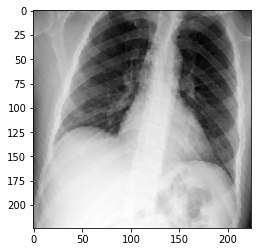

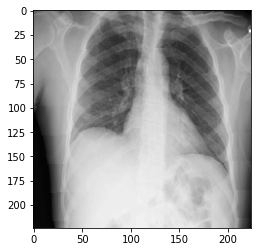

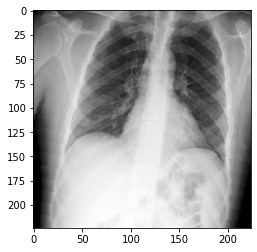

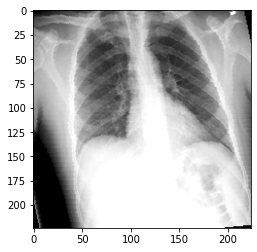

In [7]:
for i in range(4):
  train_iter = torch.utils.data.DataLoader(trainset_augment,batch_size=batch_size,shuffle=False)
  dataiter=iter(train_iter)
  images, labels = dataiter.next()
  I = images[0][0].numpy()
  plt.imshow(I,cmap='gray')
  plt.show()

- 실제 모델 학습을 위해서는 shuffle을 해주는 것이 효과적이므로 True로 변경하여 train_iter를 정의합니다.

In [0]:
train_iter = torch.utils.data.DataLoader(trainset_augment,batch_size=batch_size,shuffle=True)

## PyTorch Hub
- PyTorch에서는 resnet, densenet 등 유명한 network를 쉽게 불러와서 활용할 수 있습니다.
- Input은 color image를 기준으로 네트워크 모델이 구현이 되어 있으므로, 1채널 input(흑백영상)을 활용할 때에는 model에 대한 수정이 필요합니다. 여기에서는 input을 넣을 때에 1채널을 동일하게 반복하여 넣는 방식을 사용하였습니다.
- Output의 개수는 class의 개수에 맞게 수정해 주어야 합니다.
- 활용할 수 있는 model을 아래를 참고합니다.
- https://pytorch.org/hub/research-models 

In [9]:
net = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)

# setting hyper-parameters
learning_rate = 0.05
num_epochs = 25
num_workers = 0

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


- 아래와 같이 layer들이 가지고 있는 requires_grad=False로 하여 parameter가 변하지 않게 할 수 있습니다.

In [10]:
for param in net.parameters():
  param.requires_grad = False
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

- 새로 정의되는 layer는 default가 requires_grad = True이므로, 아래와 같이 마지막 layer를 우리의 output category 숫자에 맞게 바꾸어 주면 마지막 layer는 parameter가 변경될 수 있게 세팅이 됩니다.

In [0]:
net.fc = nn.Linear(512,3,bias=True)

In [12]:
for param in net.parameters():
  print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True


In [0]:
#Initialization of Weights
net = net.to(device)

# loss function and algorithm
loss = torch.nn.CrossEntropyLoss() # loss
alg = torch.optim.SGD(net.parameters(),lr=learning_rate) # sgd

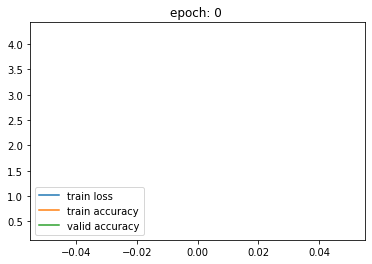

train loss:  4.23417002360026
train accuracy:  0.37533333897590637
valid accuracy:  0.3333333432674408


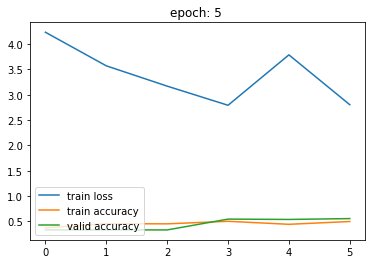

train loss:  2.804021453857422
train accuracy:  0.49933332204818726
valid accuracy:  0.5566666722297668


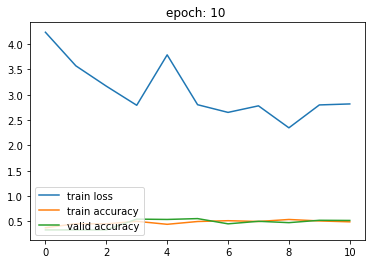

train loss:  2.8193326314290363
train accuracy:  0.49266666173934937
valid accuracy:  0.5199999809265137


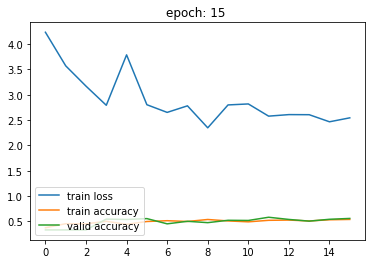

train loss:  2.5449956258138022
train accuracy:  0.5400000214576721
valid accuracy:  0.5600000023841858


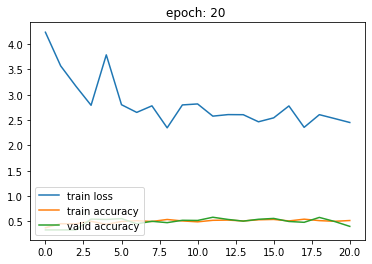

train loss:  2.453252410888672
train accuracy:  0.518666684627533
valid accuracy:  0.4033333361148834


In [14]:
# training the model
loss_train = np.array([])
accs_train = np.array([])
accs_valid = np.array([])

for epoch in range(num_epochs):
  net.train()
  i=0
  l_epoch = 0
  correct = 0
  for X,y in train_iter:
    i=i+1
    X,y = X.to(device),y.to(device)
    y_hat=net(X.repeat(1, 3, 1, 1))
    correct += (y_hat.argmax(dim=1)==y).sum()
    l=loss(y_hat,y)
    l_epoch+=l
    alg.zero_grad()
    l.backward()
    alg.step()  

  loss_train = np.append(loss_train,l_epoch.cpu().detach().numpy()/i)
  accs_train = np.append(accs_train,correct.cpu()/np.float(len(trainset)))

  correct = 0
  net.eval()
  for X,y in valid_iter:
    X,y = X.to(device),y.to(device)
    y_hat=net(X.repeat(1, 3, 1, 1))
    correct += (y_hat.argmax(dim=1)==y).sum()
  accs_valid = np.append(accs_valid,correct.cpu()/np.float(len(validset)))


  if epoch%5 == 0:
    plt.plot(loss_train,label='train loss')
    plt.plot(accs_train,label='train accuracy')
    plt.plot(accs_valid,label='valid accuracy')
    plt.legend(loc='lower left')
    plt.title('epoch: %d '%(epoch))
    plt.pause(.0001)

    print('train loss: ',loss_train[-1])
    print('train accuracy: ',accs_train[-1])
    print('valid accuracy: ',accs_valid[-1])

- 다음으로, 나머지 layer들도 parameter가 변할 수 있게 하고 learning rate를 조금 낮추어서 학습을 이어서 합니다.

In [0]:
for param in net.parameters():
  param.requires_grad = True

# setting hyper-parameters
learning_rate = 0.005
num_epochs = 25

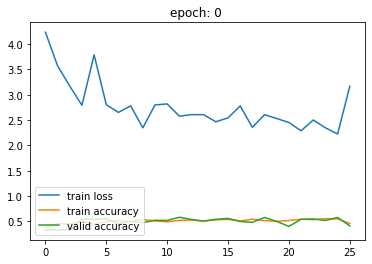

train loss:  3.1664942423502604
train accuracy:  0.4606666564941406
valid accuracy:  0.41333332657814026


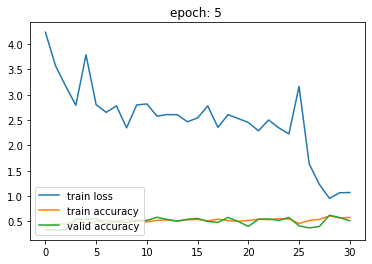

train loss:  1.071441650390625
train accuracy:  0.5786666870117188
valid accuracy:  0.5133333206176758


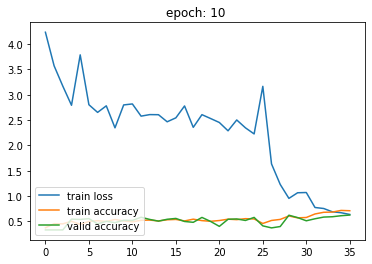

train loss:  0.638198725382487
train accuracy:  0.7120000123977661
valid accuracy:  0.6266666650772095


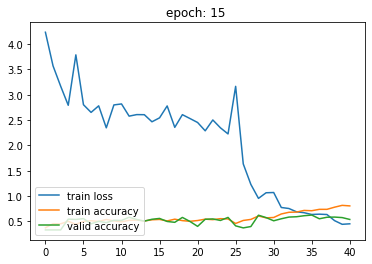

train loss:  0.45384626388549804
train accuracy:  0.8073333501815796
valid accuracy:  0.5400000214576721


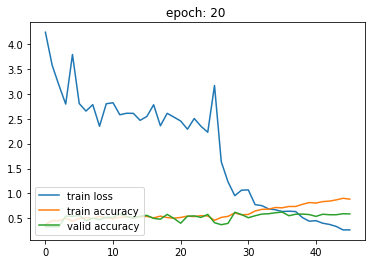

train loss:  0.26958220799764
train accuracy:  0.8859999775886536
valid accuracy:  0.5899999737739563


In [16]:
for epoch in range(num_epochs):
  net.train()
  i=0
  l_epoch = 0
  correct = 0
  for X,y in train_iter:
    i=i+1
    X,y = X.to(device),y.to(device)
    y_hat=net(X.repeat(1, 3, 1, 1))
    correct += (y_hat.argmax(dim=1)==y).sum()
    l=loss(y_hat,y)
    l_epoch+=l
    alg.zero_grad()
    l.backward()
    alg.step()  

  loss_train = np.append(loss_train,l_epoch.cpu().detach().numpy()/i)
  accs_train = np.append(accs_train,correct.cpu()/np.float(len(trainset)))

  correct = 0
  net.eval()
  for X,y in valid_iter:
    X,y = X.to(device),y.to(device)
    y_hat=net(X.repeat(1, 3, 1, 1))
    correct += (y_hat.argmax(dim=1)==y).sum()
  accs_valid = np.append(accs_valid,correct.cpu()/np.float(len(validset)))


  if epoch%5 == 0:
    plt.plot(loss_train,label='train loss')
    plt.plot(accs_train,label='train accuracy')
    plt.plot(accs_valid,label='valid accuracy')
    plt.legend(loc='lower left')
    plt.title('epoch: %d '%(epoch))
    plt.pause(.0001)

    print('train loss: ',loss_train[-1])
    print('train accuracy: ',accs_train[-1])
    print('valid accuracy: ',accs_valid[-1])

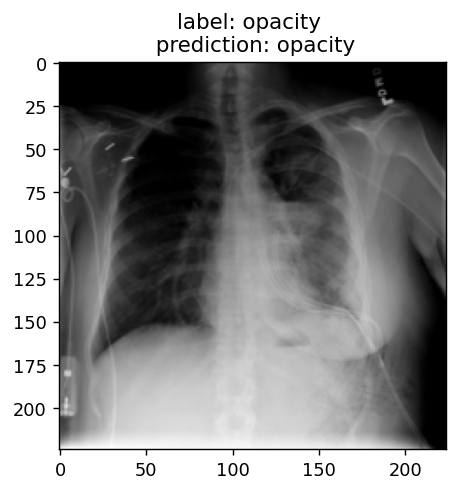

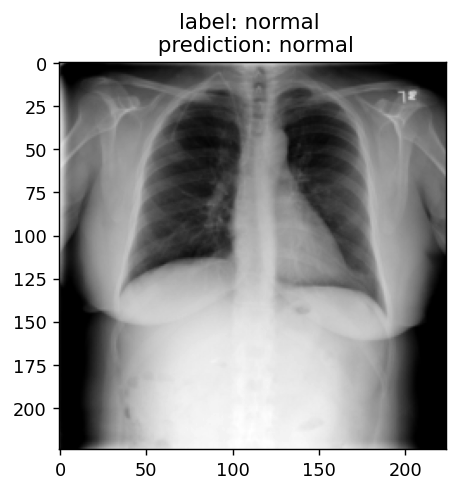

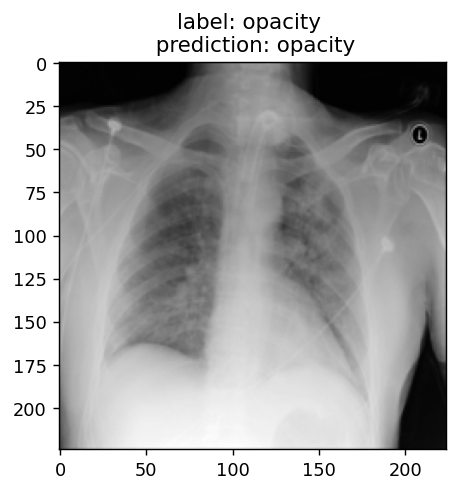

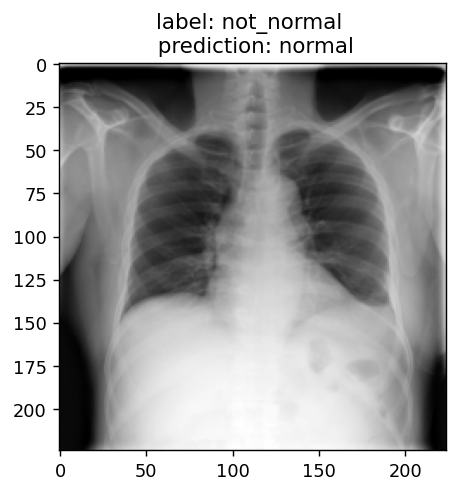

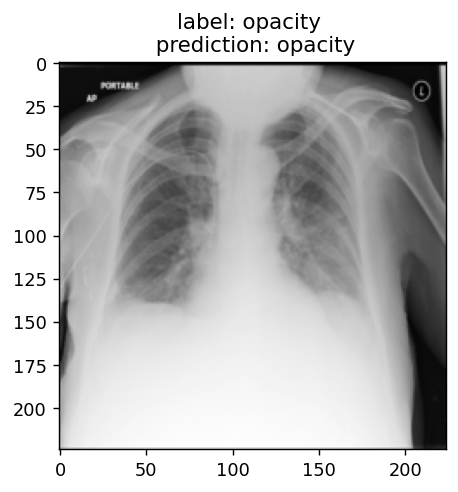

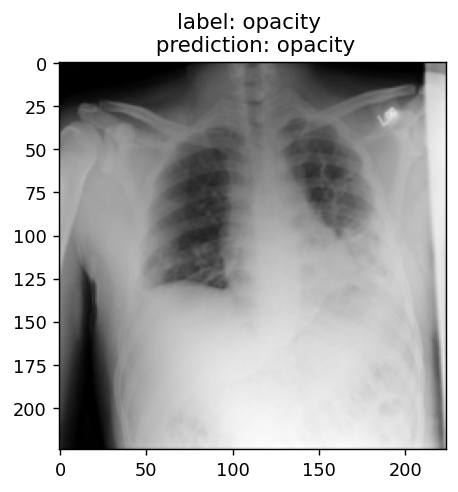

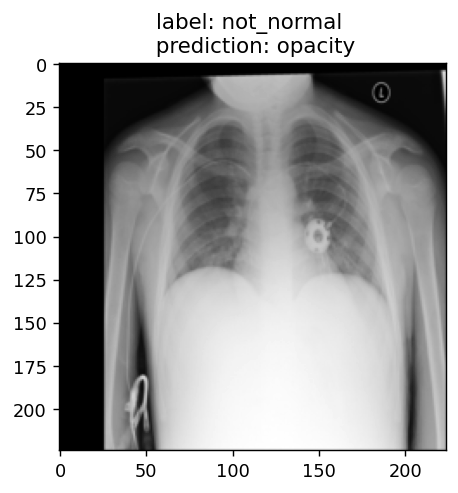

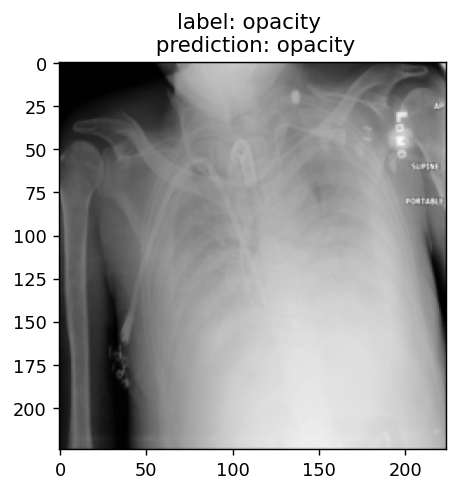

In [17]:
i = 0
net.eval()
for X,y in valid_iter:
  i=i+1
  X=X.to(device)
  y_hat = net(X.repeat((1,3,1,1)))    
  y_hat = y_hat.argmax(dim=1)
  for n in range(8):
    plt.figure(dpi=128)
    plt.imshow(X[n].cpu().squeeze(),cmap='gray')
    plt.title('label: %s \n prediction: %s'%(tgtnames[y[n]],tgtnames[y_hat[n]]))
    plt.pause(.0001)
  if i>0:
     break